In [1]:
using CSV
using DataFrames
using Hungarian
using InferOpt
using Flux
using UnicodePlots
using StatsBase
using MLJ
using ProgressMeter
using Distances
using Random

In [2]:
using JuMP
using MathOptInterface
using Gurobi
using Graphs
using Plots
using JLD2
using FileIO

In [3]:
include("assingment_Util.jl")

display_solution_old (generic function with 1 method)

In [4]:
ENV["COLUMNS"] = 100
ENV["LINES"] = 100
Random.seed!(67);

In [5]:
file = File(format"JLD2", "Data/train_data.jld2")
train_data = JLD2.load(file)

Dict{String, Any} with 4 entries:
  "Y"   => [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 1; … ; 0 0 … 0 0;…
  "X"   => Array{Float32, 3}[[0.0 1.0 … 1.0 0.0; 0.163556 0.859844 … 0.297643 0.799328; 45.0 14.0 ……
  "X_A" => DataFrame[46×9 DataFrame…
  "X_C" => DataFrame[47×9 DataFrame…

In [6]:
file = File(format"JLD2", "Data/test_data.jld2")
test_data = JLD2.load(file)

Dict{String, Any} with 4 entries:
  "Y"   => [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0;…
  "X"   => Array{Float32, 3}[[1.0 1.0 … 0.0 0.0; 0.209059 0.375959 … 0.321739 0.205797; 41.0 23.0 ……
  "X_A" => DataFrame[70×9 DataFrame…
  "X_C" => DataFrame[120×9 DataFrame…

In [7]:
X_train, X_A_train, X_C_train, Y_train = train_data["X"], train_data["X_A"], train_data["X_C"], train_data["Y"];

In [8]:
X_test, X_A_test, X_C_test, Y_test = test_data["X"], test_data["X_A"], test_data["X_C"], test_data["Y"];

In [9]:
"""
optimizer(cost_matrix)

Wrapper function for the hungarian assignment algorithm.
"""
function optimizer(cost_matrix)
    vector = hungarian(-cost_matrix)[1]
    n, m = size(cost_matrix)

    # Create a matrix of size n×n filled with 0's
    matrix = zeros(Int, n, m)

    # Set the value to 1 at the specified points in the vector
    for i in 1:length(vector)
        matrix[i, vector[i]] = 1
    end
    return matrix
end

optimizer

In [10]:
optimizer_layer = PerturbedMultiplicative(optimizer; ε=0.5, nb_samples=5, seed=69);
loss = FenchelYoungLoss(optimizer_layer);

In [11]:
og_encoder = Chain(
  Dense(4, 1),
  z -> dropdims(z; dims=1),
)

Chain(
  Dense(4 => 1),                        # 5 parameters
  var"#50#51"(),
) 

In [12]:
# Create a copy of the original encoder
encoder = deepcopy(og_encoder)

# Initialize the optimizer
opt_state = Flux.setup(Adam(), encoder)

# Initialize the losses array
losses = Float64[]
best_loss = Inf
best_model = deepcopy(encoder)

# Define the early stopping criterion
es = Flux.early_stopping(() -> best_loss, 5)

@showprogress 30 "Training model..." for epoch in 1:100
    l = 0.0
    # Iterate through each data point
    for (x, y) in zip(X_train, Y_train)
        # Calculate gradients using the current data point
        val, grads = Flux.withgradient(encoder) do m
            # Any code inside here is differentiated.
            # Evaluation of the model and loss must be inside!
            result = m(x)
            loss(result, y)
        end
        l+= val
        # Update the model parameters using the calculated gradients
        Flux.update!(opt_state, encoder, grads[1])
    end

    # Calculate average loss for this epoch
    average_loss = l / length(X_train)

    # Check for improvement 
    if average_loss < best_loss && average_loss >= 0
        best_loss = average_loss
        best_model = deepcopy(encoder)
    else
        if es()
            break
        end
    end

    # Append the average loss to the losses array
    push!(losses, average_loss)
end
encoder = best_model  # set encoder to the best model


Training model...   2%|█                                 |  ETA: 0:36:13

Training model...   8%|███                               |  ETA: 0:14:33

Training model... 100%|██████████████████████████████████| Time: 0:01:30


Chain(
  Dense(4 => 1),                        # 5 parameters
  var"#50#51"(),
) 

In [13]:
lineplot(losses; xlabel="Epoch", ylabel="Loss")

              ┌────────────────────────────────────────┐ 
        2 000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠘⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Loss       │⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            0 │⠀⠀⠀⠀⠉⠒⠢⢄⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              └────────────────────────────────────────┘ 
              

In [14]:
Y_test_pred = [optimizer(encoder(x)) for x in X_test];

In [15]:
pred_deliveries, pred_constraints = create_deliveries(X_A_test, X_C_test, Y_test_pred)
true_deliveries, true_constraints = create_deliveries(X_A_test, X_C_test, Y_test)

(Any[Any[Delivery(5.126374877523316, 4.406390187627437), Delivery(5.1204729157687865, 4.334089906634947), Delivery(5.036515647493489, 3.6036883394790844), Delivery(5.051932414400978, 3.5303819557872007), Delivery(5.1303406268326714, 4.296859465636211), Delivery(5.1204729157687865, 4.334089906634947), Delivery(5.132955076513357, 4.639858420562722), Delivery(5.134041500871803, 4.598190619749294), Delivery(5.081140133034815, 4.121061264108667), Delivery(5.07584980205084, 3.7626139343616054)  …  Delivery(4.9126008409149176, 4.209983181019458), Delivery(4.913548990898646, 4.175628404514657), Delivery(4.895501841898249, 4.099008184338153), Delivery(4.902555315701303, 3.9596151888925597), Delivery(4.935536208681828, 4.061245525564403), Delivery(4.884667714272846, 3.965063684612284), Delivery(5.013164114122896, 4.346298301241377), Delivery(5.008799200904464, 4.314894454882154), Delivery(5.026286056693232, 4.401612044016113), Delivery(5.025902115999137, 4.417031359969121)], Any[Delivery(4.96763

In [16]:
solution = solve_tsp(pred_deliveries[1], pred_constraints[1], Gurobi.Optimizer)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


([0.0 -0.0 … -0.0 -0.0; -0.0 0.0 … -0.0 -0.0; … ; -0.0 -0.0 … 0.0 -0.0; -0.0 -0.0 … -0.0 0.0], 5.4340364152591825)

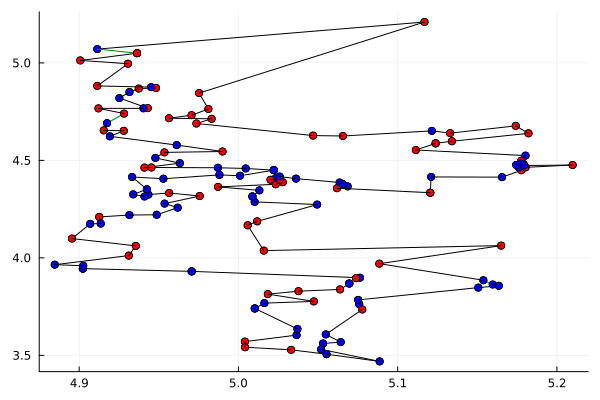

In [17]:
display_solution(pred_deliveries[1], solution[1])

In [18]:
pred_solution = []
@showprogress 120 "progress ..." for (delivery, constraint) in zip(pred_deliveries, pred_constraints)
   push!(pred_solution, solve_tsp(delivery, constraint, Gurobi.Optimizer));
end

progress ...   2%|█                                      |  ETA: 2:55:45

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   3%|██                                     |  ETA: 4:01:02

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   4%|██                                     |  ETA: 15:39:18

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   5%|██                                     |  ETA: 14:34:12

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   7%|███                                    |  ETA: 10:49:11

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  10%|████                                   |  ETA: 8:05:03

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  12%|█████                                  |  ETA: 6:43:29

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  15%|██████                                 |  ETA: 5:41:36

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  16%|███████                                |  ETA: 5:21:40

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  19%|████████                               |  ETA: 4:37:35

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  21%|█████████                              |  ETA: 4:12:18

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  25%|██████████                             |  ETA: 3:33:26

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  27%|███████████                            |  ETA: 3:18:27

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  28%|████████████                           |  ETA: 3:09:11

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  30%|████████████                           |  ETA: 3:06:30

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  31%|█████████████                          |  ETA: 2:59:02

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  32%|█████████████                          |  ETA: 2:54:44

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  34%|██████████████                         |  ETA: 2:42:36

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  36%|███████████████                        |  ETA: 2:39:11

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  38%|███████████████                        |  ETA: 2:33:41

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  40%|████████████████                       |  ETA: 2:23:24

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  42%|█████████████████                      |  ETA: 2:15:02

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  45%|██████████████████                     |  ETA: 2:01:00

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  48%|███████████████████                    |  ETA: 1:51:18

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  52%|█████████████████████                  |  ETA: 1:35:39

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  56%|███████████████████████                |  ETA: 1:27:22

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  58%|███████████████████████                |  ETA: 1:23:39

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  60%|████████████████████████               |  ETA: 1:19:57

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  61%|████████████████████████               |  ETA: 1:20:11

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  63%|█████████████████████████              |  ETA: 1:18:04

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  65%|██████████████████████████             |  ETA: 1:15:40

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  66%|██████████████████████████             |  ETA: 1:14:29

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  66%|██████████████████████████             |  ETA: 1:14:04

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  67%|███████████████████████████            |  ETA: 1:11:59

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  68%|███████████████████████████            |  ETA: 1:09:28

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  69%|████████████████████████████           |  ETA: 1:07:21

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  72%|████████████████████████████           |  ETA: 1:03:18

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  73%|█████████████████████████████          |  ETA: 0:59:21

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  74%|█████████████████████████████          |  ETA: 0:57:23

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  76%|██████████████████████████████         |  ETA: 0:51:52

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  78%|███████████████████████████████        |  ETA: 0:47:13

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  80%|████████████████████████████████       |  ETA: 0:43:22

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  85%|██████████████████████████████████     |  ETA: 0:33:07

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  86%|██████████████████████████████████     |  ETA: 0:30:50

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  88%|███████████████████████████████████    |  ETA: 0:27:20

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  90%|████████████████████████████████████   |  ETA: 0:21:18

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  92%|████████████████████████████████████   |  ETA: 0:17:38

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  94%|█████████████████████████████████████  |  ETA: 0:14:02

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  95%|█████████████████████████████████████  |  ETA: 0:11:42

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  97%|██████████████████████████████████████ |  ETA: 0:05:45

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ... 100%|███████████████████████████████████████| Time: 3:28:35


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


In [19]:
file = File(format"JLD2", "Data/multi_output.jld2")
  
# Save data into the file
save(file, "delivery", pred_deliveries, "constraint", pred_constraints, "solutions", pred_solution)